Цель довольно простая

In [27]:
import json

import numpy as np

with open("short_term_dataset.json", "r") as f:
    df_json = json.load(f)

In [28]:
import pandas as pd

df = pd.DataFrame(df_json)

df[['prev_val_1', 'prev_val_2', 'prev_val_3', 'prev_val_4', 'prev_val_5', 'prev_val_6', 'prev_val_7']] = pd.DataFrame(df['prev_values'].tolist(), index=df.index)
df.drop(columns=['prev_values'], inplace=True)

In [29]:
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091973 entries, 0 to 2091972
Data columns (total 13 columns):
 #   Column       Dtype  
---  ------       -----  
 0   price        float64
 1   gtin         object 
 2   item_group   object 
 3   day_of_week  object 
 4   date         object 
 5   y_true       float64
 6   prev_val_1   float64
 7   prev_val_2   float64
 8   prev_val_3   float64
 9   prev_val_4   float64
 10  prev_val_5   float64
 11  prev_val_6   float64
 12  prev_val_7   float64
dtypes: float64(9), object(4)
memory usage: 207.5+ MB


In [30]:
df['price'] = df['price']/100
df.drop(columns=['item_group'], inplace=True)


df[['month', 'day']] = df['date'].str.split('-', expand=True)

# Convert month and day columns to integers
df['month'] = df['month'].astype(int)

df['day'] = df['day'].astype(int)

df.drop(columns=['date'], inplace=True)

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder

preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(), ['day_of_week'])],
    remainder='passthrough',
)

ridge_reg = Pipeline(steps=[('preprocessor', preprocessor),
                            ('regression_ridge', Ridge())])

# df['Monday'] = (df['day_of_week']=='Понедельник').astype(int)
# df['Tuesday'] = (df['day_of_week']=='Вторник').astype(int)
# df['Wednesday'] = (df['day_of_week'] == 'Среда').astype(int)
# df['Thursday'] = (df['day_of_week']=='Четверг').astype(int)
# df['Friday'] = (df['day_of_week'] == 'П\ятница').astype(int)
# df['Saturday'] = (df['day_of_week'] == 'Суббота').astype(int)
# df['Sunday'] = (df['day_of_week'] == 'Воскресенье').astype(int)

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['gtin', 'y_true', 'day', 'month']), df['y_true'], test_size=0.2, random_state=44)



In [32]:
ridge_reg.fit(X_train, y_train)
print("Score:", ridge_reg.score(X_test, y_test))
print("MAE:", mean_absolute_error(ridge_reg.predict(X_test), y_test))


Score: 0.703674356952751
MAE: 1.0124982260719189


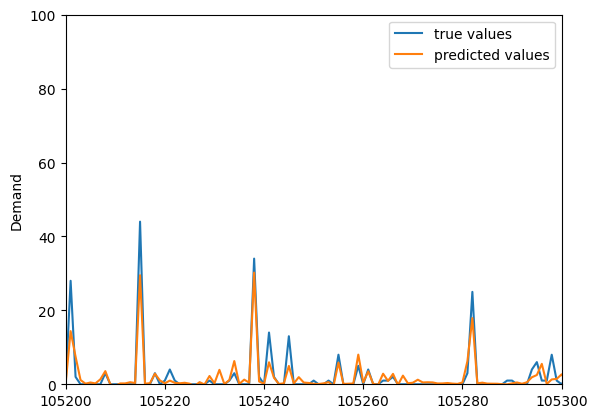

In [33]:

from matplotlib import pyplot as plt


def show_adekvantost(true, predict):
    plt.plot(true.reset_index(drop=True), label='true values')
    plt.plot(predict, label='predicted values')
    plt.ylabel("Demand")
    plt.legend()
    plt.xlim(105200, 105300)
    plt.ylim(0, 100)
    plt.show()

predicts = ridge_reg.predict(X_test)
show_adekvantost(y_test, predicts)


Можно видеть, что линрег отлично справился со своей задачей и достаточно точно предсказывает спрос. Прям будто очень хорошо. Я прошёлся графиком по нескольким сотням строчек и видно, что тренды довольно точно b адекватно предсказываются.
Теперь думаю попробовать использовать catBoost и RandomForest, посмотрим, насколько лучше метрики себя будут вести и т.д.


In [34]:
from sklearn.ensemble import RandomForestRegressor

random_forest = Pipeline(steps=[('preprocessor', preprocessor), ('rfr', RandomForestRegressor(n_jobs=-1, n_estimators=20))])

random_forest.fit(X_train, y_train)
print("Score:", random_forest.score(X_test, y_test))
print("MAE:", mean_absolute_error(random_forest.predict(X_test), y_test))

Score: 0.7894401570106566
MAE: 0.84640527671567


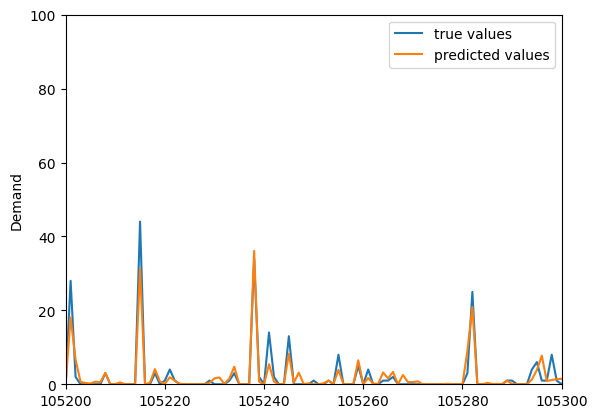

In [35]:
rf_predicts = random_forest.predict(X_test)
show_adekvantost(y_test, rf_predicts)


Random forest показал себя лучше линрега (удивительно)

In [36]:
import catboost as cb

cb_reg = Pipeline(steps=[('preprocessor', preprocessor),
                            ('catboost', cb.CatBoostRegressor())])

cb_reg.fit(X_train, y_train)
print("Score:", cb_reg.score(X_test, y_test))
print("MAE:", mean_absolute_error(cb_reg.predict(X_test), y_test))

Learning rate set to 0.132287
0:	learn: 6.0728896	total: 81.8ms	remaining: 1m 21s
1:	learn: 5.5834916	total: 176ms	remaining: 1m 27s
2:	learn: 5.1717804	total: 253ms	remaining: 1m 24s
3:	learn: 4.8267746	total: 335ms	remaining: 1m 23s
4:	learn: 4.5337840	total: 415ms	remaining: 1m 22s
5:	learn: 4.2866578	total: 498ms	remaining: 1m 22s
6:	learn: 4.0809406	total: 575ms	remaining: 1m 21s
7:	learn: 3.9045956	total: 660ms	remaining: 1m 21s
8:	learn: 3.7629599	total: 741ms	remaining: 1m 21s
9:	learn: 3.6412997	total: 824ms	remaining: 1m 21s
10:	learn: 3.5350712	total: 927ms	remaining: 1m 23s
11:	learn: 3.4490075	total: 1.01s	remaining: 1m 23s
12:	learn: 3.3780020	total: 1.1s	remaining: 1m 23s
13:	learn: 3.3195841	total: 1.18s	remaining: 1m 23s
14:	learn: 3.2672262	total: 1.27s	remaining: 1m 23s
15:	learn: 3.2223895	total: 1.35s	remaining: 1m 22s
16:	learn: 3.1852557	total: 1.44s	remaining: 1m 23s
17:	learn: 3.1536192	total: 1.52s	remaining: 1m 23s
18:	learn: 3.1241756	total: 1.61s	remaining:

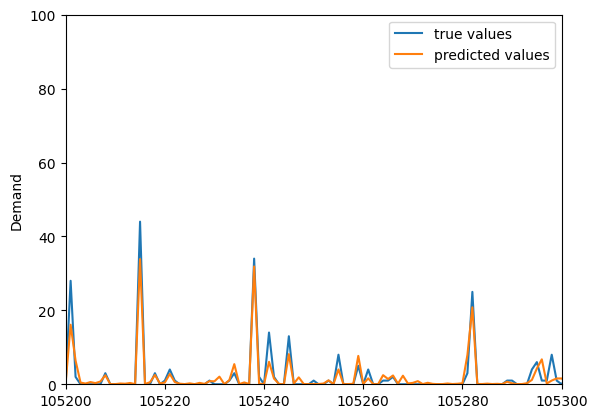

In [37]:
cb_predicts = cb_reg.predict(X_test)
show_adekvantost(y_test, cb_predicts)

CatBoost regressor пока что показывает самые лучшие данные по метрикам, по графикам методом зоркого взгляда разницы уже не ощущается. Надо подумать что ещё можно было бы заюзать, хотя мне кажется, что этого достаточно, и стоит думать, а как мне теперь улучшить датасет. Сделать его плотнее и убрать те продукты у которых спрос как у говна? Вероятно, это повысит качество предсказываний. Но в реале то будут и говно загружать в датасет не?

Обновление: посмотрим, а как будет меняться предсказание спроса при изменении цены. Возьмём например какой-то товар из X_test у которого каждый день есть какой-то регулярный спрос. Нам подходит товар с индексом 1104296, у него каждый день есть спрос.

In [38]:
print(X_test.loc[[1104296]])

          price day_of_week  prev_val_1  prev_val_2  prev_val_3  prev_val_4  \
1104296  705.75     Пятница        11.0        15.0        15.0         7.0   

         prev_val_5  prev_val_6  prev_val_7  
1104296        14.0         3.0        19.0  


C:\Users\1812s\AppData\Local\Temp\ipykernel_12904\2758770711.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  product_to_analysis = product_to_analysis.append(new_row)
C:\Users\1812s\AppData\Local\Temp\ipykernel_12904\2758770711.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  product_to_analysis = product_to_analysis.append(new_row)
C:\Users\1812s\AppData\Local\Temp\ipykernel_12904\2758770711.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  product_to_analysis = product_to_analysis.append(new_row)
C:\Users\1812s\AppData\Local\Temp\ipykernel_12904\2758770711.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  product_to_analysi

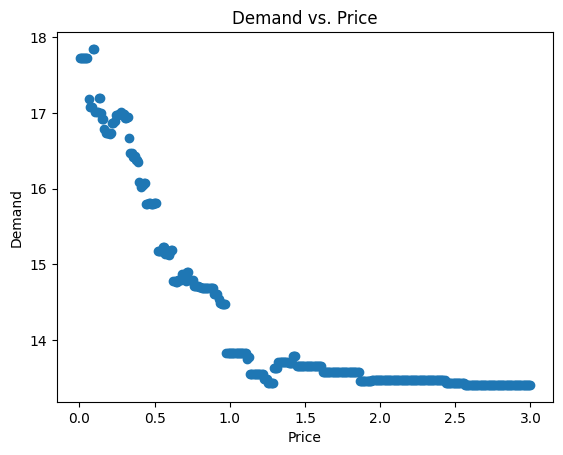

In [39]:

def show_demand_price(product_to_analysis):
    price_coeffs = np.linspace(0.001, 3, 400)
    for i in price_coeffs:
        new_row = product_to_analysis.iloc[0].copy()
        new_row['price']*=i
        product_to_analysis = product_to_analysis.append(new_row)
    product_to_analysis.reset_index(drop=True, inplace=True)
    product_to_analysis = product_to_analysis.drop(0)

    predicts = cb_reg.predict(product_to_analysis)
    plt.scatter(price_coeffs, predicts)
    plt.xlabel('Price')
    plt.ylabel('Demand')
    plt.title('Demand vs. Price')

    plt.show()


some_product = X_test.loc[[1104296]]

show_demand_price(some_product)

C:\Users\1812s\AppData\Local\Temp\ipykernel_12904\2758770711.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  product_to_analysis = product_to_analysis.append(new_row)
C:\Users\1812s\AppData\Local\Temp\ipykernel_12904\2758770711.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  product_to_analysis = product_to_analysis.append(new_row)
C:\Users\1812s\AppData\Local\Temp\ipykernel_12904\2758770711.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  product_to_analysis = product_to_analysis.append(new_row)
C:\Users\1812s\AppData\Local\Temp\ipykernel_12904\2758770711.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  product_to_analysi

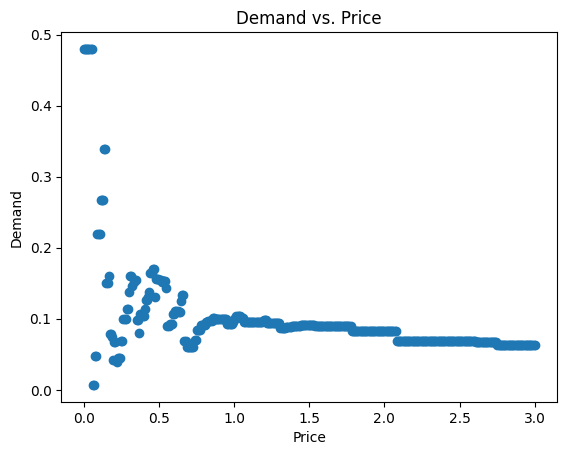

In [40]:
X_test.head(100) #1308195
some_bad_product = X_test.loc[[1308195]]
show_demand_price(some_bad_product)

Для малопопулярных товаров кривая спроса-цены строится уже хуже, при снижении цены начинаются непредсказуемое...

А вообще, думаю мы достаточно сделали. Сохраним результат обучения лучшей модели (пока что) - CatBoostRegressor

In [41]:
import pickle

with open('cv_reg.pkl', 'wb') as file:
    pickle.dump(cb_reg, file)